## 1. Calibrate camera

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob


def calibrate_camera(images, nx=9, ny=6):             
    objpoints = []  # 3D points in real world space
    imgpoints = []  # 2D points in image plane
    
    # Prepare object points, like (0,0,0), (1,0,0), ..., (nx,ny,0)
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)  # x, y coordinates
    
    for img_path in images:
        img = cv2.imread(img_path)
    
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
            
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
            # cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            # plt.imshow(img)
        else:
            # TODO: why some images have no corners found???
            print('WARN: no corners was found for image: %s!!!' % img_path)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist
    
    
def undistort_image(img, mtx, dist):    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_image

WARN: no corners was found for image: camera_cal/calibration5.jpg!!!
WARN: no corners was found for image: camera_cal/calibration4.jpg!!!
WARN: no corners was found for image: camera_cal/calibration1.jpg!!!


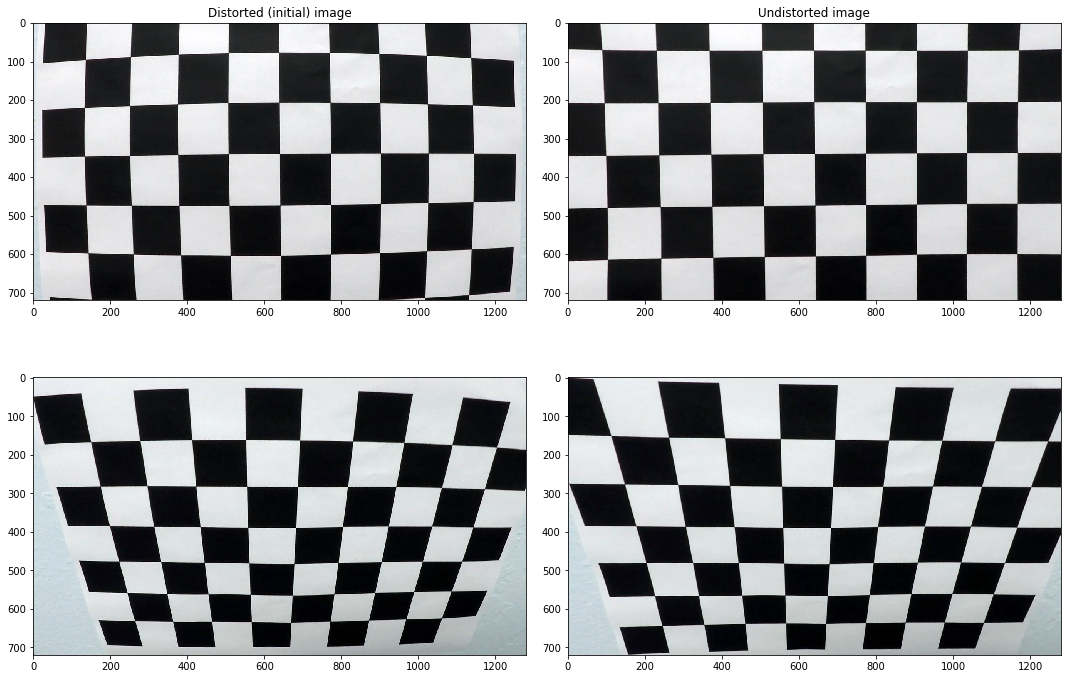

In [2]:
images = glob.glob('camera_cal/calibration*.jpg')
mtx, dist = calibrate_camera(images)

distorted_img = cv2.imread(images[6])
undistorted_img = undistort_image(distorted_img, mtx, dist)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.tight_layout()

subplot = axs[0][0]
subplot.set_title('Distorted (initial) image')
subplot.imshow(distorted_img)

subplot = axs[0][1]
subplot.set_title('Undistorted image')
subplot.imshow(undistorted_img)

distorted_img2 = cv2.imread(images[5])
undistorted_img2 = undistort_image(distorted_img2, mtx, dist)

subplot = axs[1][0]
subplot.imshow(distorted_img2)

subplot = axs[1][1]
subplot.imshow(undistorted_img2)

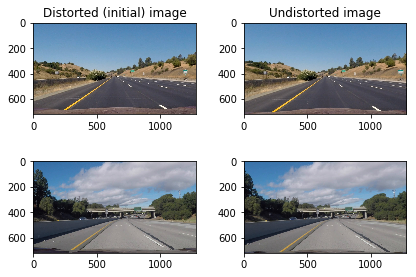

In [3]:
distorted_test_img = mpimg.imread('test_images/straight_lines1.jpg')
undistorted_test_img = undistort_image(distorted_test_img, mtx, dist)

fig, axs = plt.subplots(2, 2)
fig.tight_layout()
plt.rcParams['figure.figsize'] = 15, 10
subplot = axs[0][0]
subplot.set_title('Distorted (initial) image')
subplot.imshow(distorted_test_img)

subplot = axs[0][1]
subplot.set_title('Undistorted image')
subplot.imshow(undistorted_test_img)

distorted_challenge_img = mpimg.imread('test_images/challenge1.jpg')
undistorted_challenge_img = undistort_image(distorted_challenge_img, mtx, dist)
axs[1][0].imshow(distorted_challenge_img)
axs[1][1].imshow(undistorted_challenge_img)

## 2. Perspective transform

In [4]:
def perspective_transform(img):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
def create_vertices(img):
    imshape = img.shape
    return np.array([[ 
        (.440*imshape[1], .65*imshape[0]), 
        (.200*imshape[1], .93*imshape[0]), 
        (.820*imshape[1], .93*imshape[0]),
        (.563*imshape[1], .65*imshape[0])]], dtype=np.int32)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def print_vertice(image, ver1, ver2):
    cv2.line(image, (int(ver1[0]), int(ver1[1])), (int(ver2[0]), int(ver2[1])), [255, 0, 0], 2)
    
def show_region_of_interest(image, vertices):
    print_vertice(image, vertices[0][0], vertices[0][1])
    print_vertice(image, vertices[0][1], vertices[0][2])
    print_vertice(image, vertices[0][2], vertices[0][3])
    print_vertice(image, vertices[0][3], vertices[0][0])

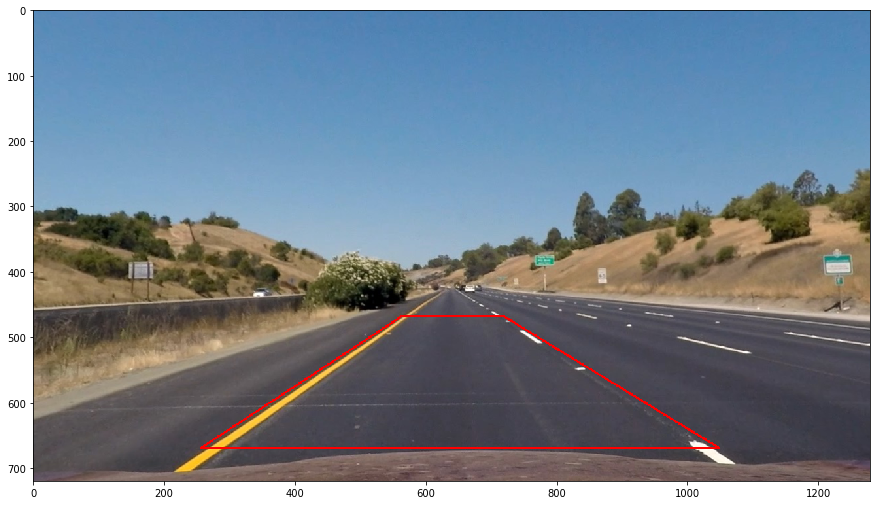

In [5]:
vertices = create_vertices(undistorted_test_img)
#masked_edges = region_of_interest(edges_img, vertices)
show_region_of_interest(undistorted_test_img, vertices)
plt.imshow(undistorted_test_img)

In [6]:
points = vertices[0]
src = np.float32(points)
print("src coordinates: \n", src)

dest = np.float32(
     [[points[1][0], 200],
      points[1],
      points[2],
     [points[2][0], 200]]
)
print("dest coordinates: \n", dest)

src coordinates: 
 [[  563.   468.]
 [  256.   669.]
 [ 1049.   669.]
 [  720.   468.]]
dest coordinates: 
 [[  256.   200.]
 [  256.   669.]
 [ 1049.   669.]
 [ 1049.   200.]]


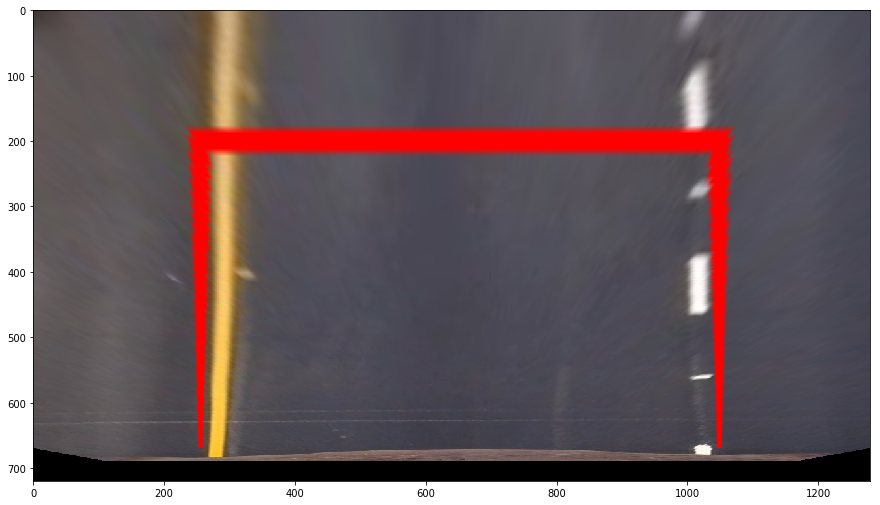

In [7]:
M = cv2.getPerspectiveTransform(src, dest)
img_size = (undistorted_test_img.shape[1], undistorted_test_img.shape[0])
warped = cv2.warpPerspective(undistorted_test_img, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped)

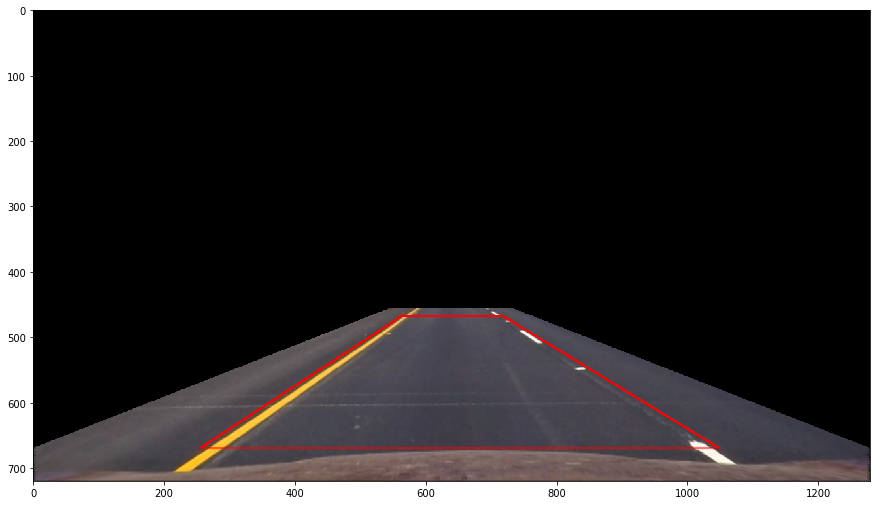

In [8]:
Minv = cv2.getPerspectiveTransform(dest, src)
unwarped = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(unwarped)

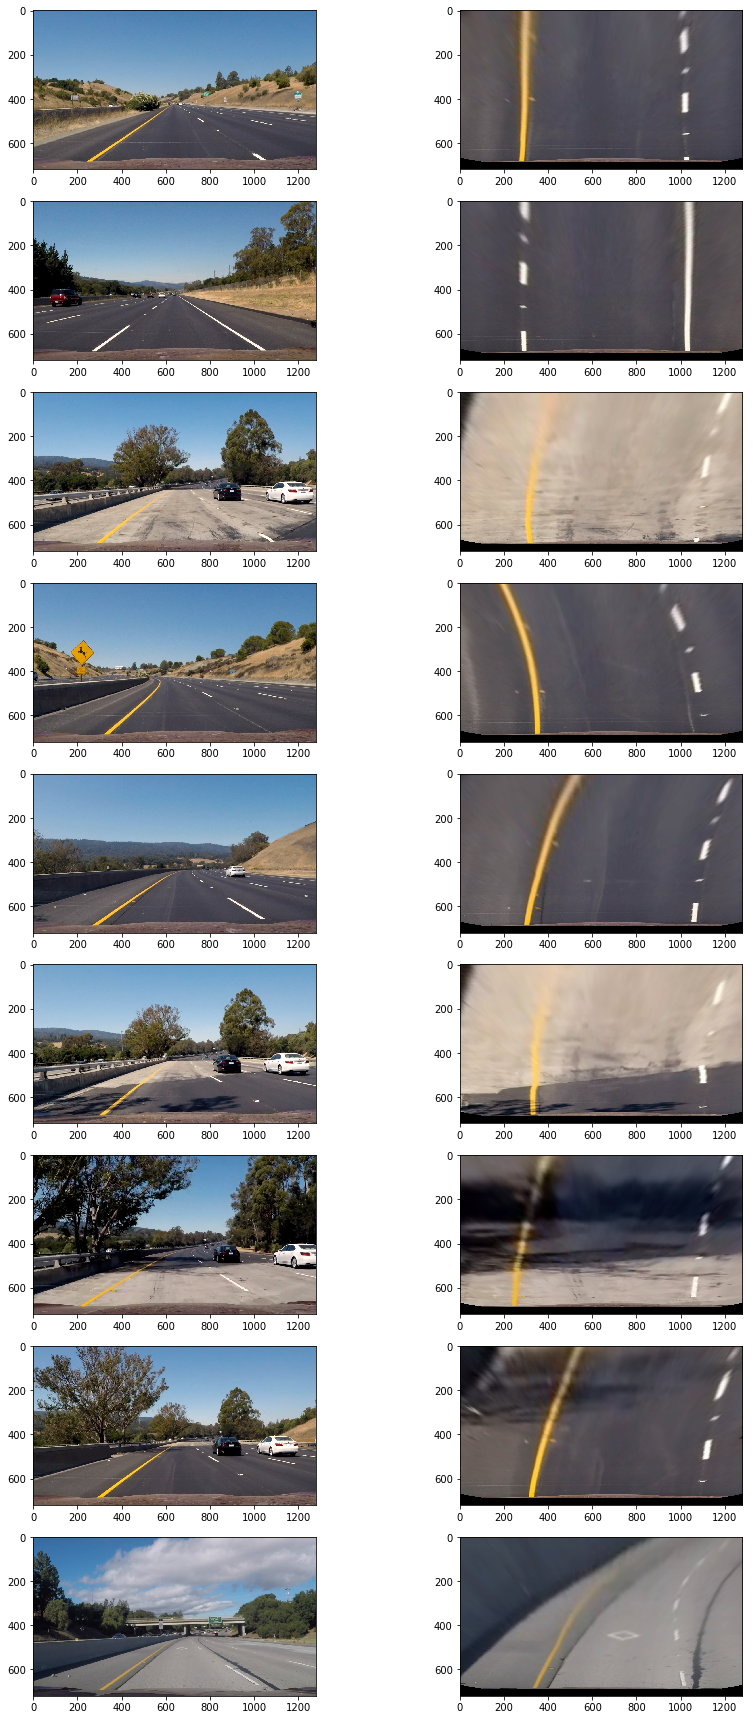

In [9]:
# Test on all test images
list_of_images = ['straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 
                  'test4.jpg', 'test5.jpg', 'test6.jpg', 'challenge1.jpg']

columns = 2
rows = len(list_of_images)

fig, axs = plt.subplots(rows, columns, figsize=(12, 24))
fig.tight_layout()

for index, img_name in enumerate(list_of_images):
    orig_img = mpimg.imread('test_images/' + img_name)
    axs[index, 0].imshow(orig_img)
    
    undistorted_img = undistort_image(orig_img, mtx, dist)
    warped_img = cv2.warpPerspective(undistorted_img, M, img_size, flags=cv2.INTER_LINEAR)
    axs[index, 1].imshow(warped_img)

## 3. Gradient and Color Spaces

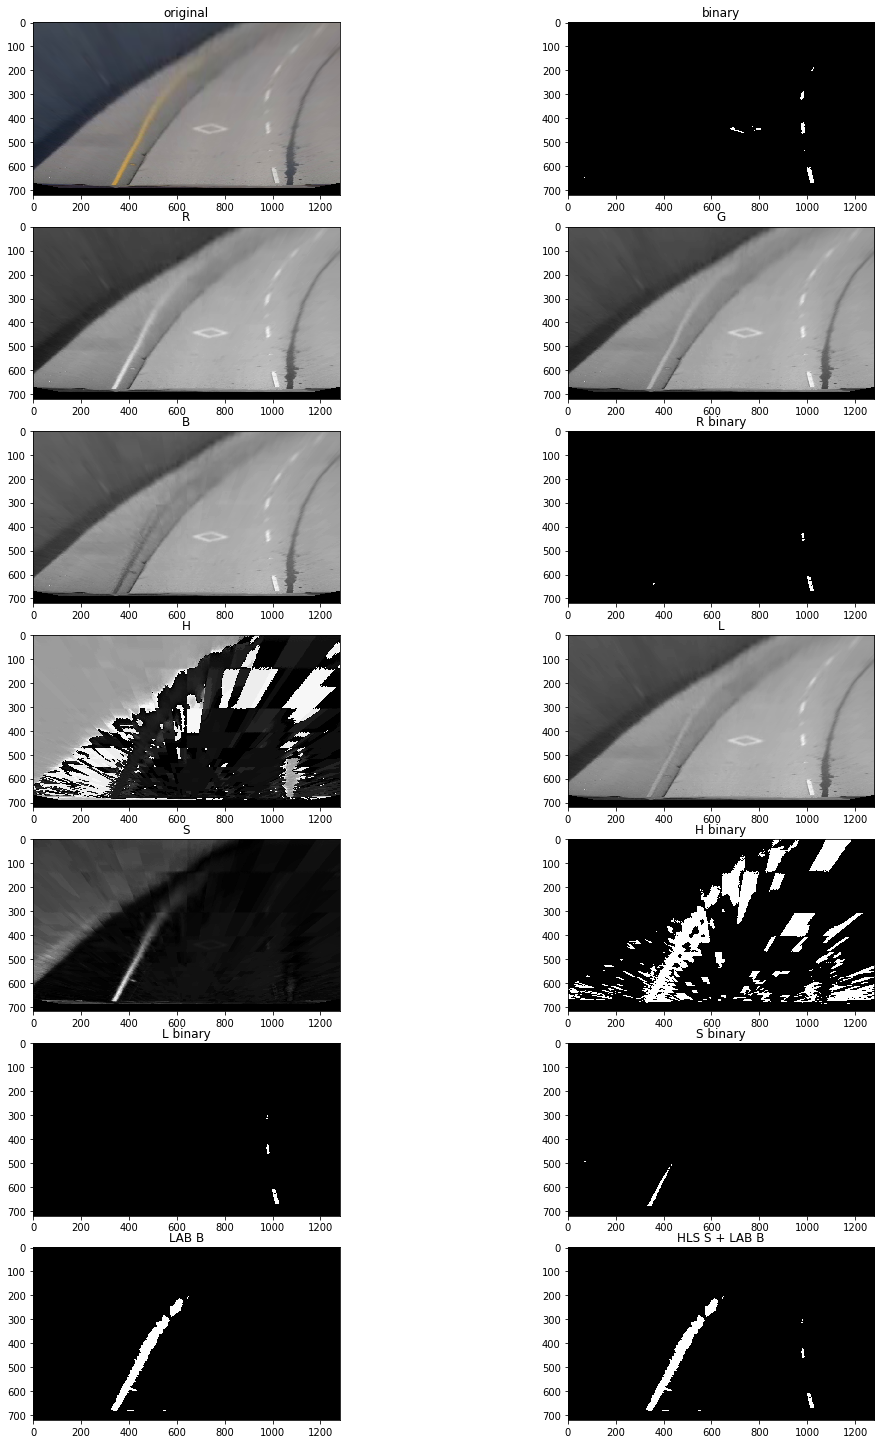

In [10]:
challenge_img = mpimg.imread('test_images/challenge1.jpg')
img_size = (orig_img.shape[1], orig_img.shape[0])
challenge_img = cv2.warpPerspective(challenge_img, M, img_size, flags=cv2.INTER_LINEAR)

fig, axs = plt.subplots(7, 2, figsize=(15, 20))
fig.tight_layout()
axs[0][0].set_title('original')
axs[0][0].imshow(challenge_img)

def binary_thres(img, thresh=(180, 255)):
    gray = cv2.cvtColor(challenge_img, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return binary

axs[0][1].set_title('binary')
axs[0][1].imshow(binary_thres(challenge_img), cmap='gray')

# RGB
R = challenge_img[:,:,0]
G = challenge_img[:,:,1]
B = challenge_img[:,:,2]
axs[1][0].set_title('R')
axs[1][0].imshow(R, cmap='gray')
axs[1][1].set_title('G')
axs[1][1].imshow(G, cmap='gray')
axs[2][0].set_title('B')
axs[2][0].imshow(B, cmap='gray')

thresh = (200, 255)
binary = np.zeros_like(R)
binary[(R > thresh[0]) & (R <= thresh[1])] = 1
axs[2][1].set_title('R binary')
axs[2][1].imshow(binary, cmap='gray')

hls = cv2.cvtColor(challenge_img, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
axs[3][0].set_title('H')
axs[3][0].imshow(H, cmap='gray')
axs[3][1].set_title('L')
axs[3][1].imshow(L, cmap='gray')
axs[4][0].set_title('S')
axs[4][0].imshow(S, cmap='gray')

thresh = (15, 100)
binary = np.zeros_like(H)
binary[(H > thresh[0]) & (H <= thresh[1])] = 1
axs[4][1].set_title('H binary')
axs[4][1].imshow(binary, cmap='gray')

def hls_lthresh(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

axs[5][0].set_title('L binary')
hls_l = hls_lthresh(challenge_img)
axs[5][0].imshow(hls_l, cmap='gray')

thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1
axs[5][1].set_title('S binary')
axs[5][1].imshow(binary, cmap='gray')

def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

axs[6][0].set_title('LAB B')
lab_b = lab_bthresh(challenge_img)
axs[6][0].imshow(lab_b, cmap='gray')

combined = np.zeros_like(lab_b)
combined[(hls_l == 1) | (lab_b == 1)] = 1
axs[6][1].set_title('HLS S + LAB B')
axs[6][1].imshow(combined, cmap='gray')

In [11]:
def pipeline(img):
    img = np.copy(img)
    
    hls_l = hls_lthresh(img)
    lab_b = lab_bthresh(img)
    combined = np.zeros_like(lab_b, dtype=np.uint8)
    combined[(hls_l == 1) | (lab_b == 1)] = 1
    
    return combined

def binary_warped(orig_img, M):
    img_size = (orig_img.shape[1], orig_img.shape[0])
    warped_img = cv2.warpPerspective(undistorted_img, M, img_size, flags=cv2.INTER_LINEAR)
    binary_warped_img = pipeline(warped_img)
    return binary_warped_img

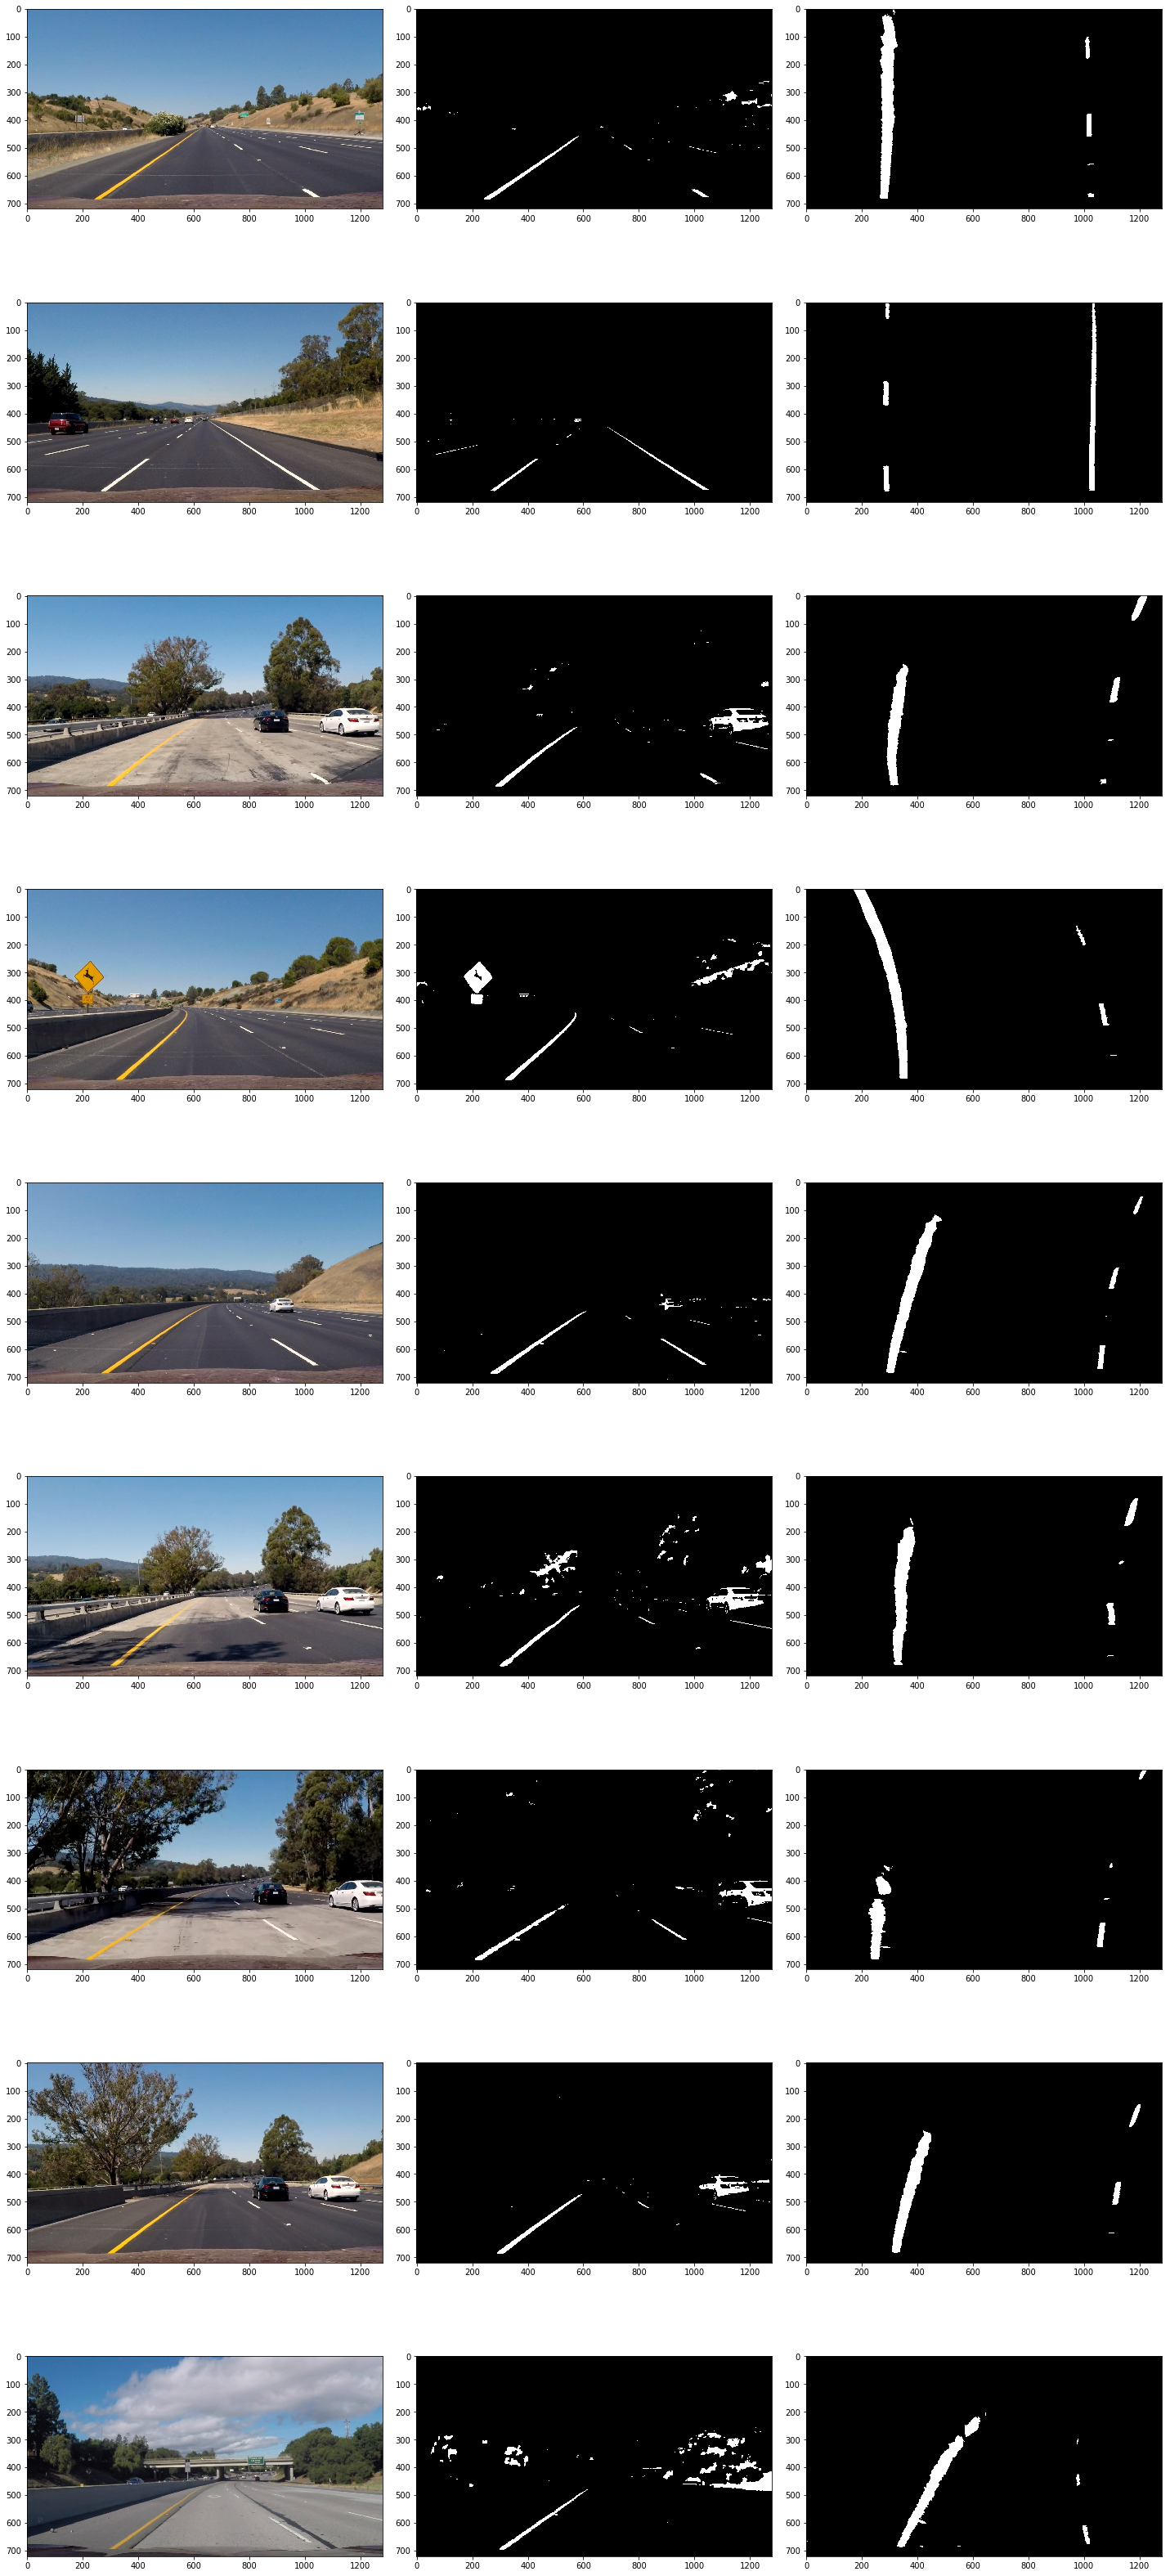

In [12]:
fig, axs = plt.subplots(rows, 3, figsize=(20, 45))
fig.tight_layout()

for index, img_name in enumerate(list_of_images):
    orig_img = mpimg.imread('test_images/' + img_name)
    axs[index, 0].imshow(orig_img)
    
    result_img = pipeline(orig_img)
    axs[index, 1].imshow(result_img, cmap='gray')
    
    undistorted_img = undistort_image(orig_img, mtx, dist)
    warped_pipe_img = binary_warped(undistorted_img, M)
    axs[index, 2].imshow(warped_pipe_img, cmap='gray')


## 4. Finding lines

In [13]:
from scipy.signal import savgol_filter

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # last n fits count used to smoothe line
        self.smoothing_window = 51
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        # For visualizations
        self.search_windows = []
        self.search_margin = None
        
        self.best_fit_history = []
             
    def fit(self, ploty):
        # Polyfit line
        self.current_fit.append(np.polyfit(self.ally, self.allx, 2))

        # best fit
        if len(self.current_fit) < self.smoothing_window:
            ## Not enough history, just take last one
            self.best_fit = self.current_fit[-1]
        else:
            # Resize history
            #self.current_fit = self.current_fit[-self.history_size:]
            # Use savgol filter to smooth
            #print(self.current_fit)
            smoothed_fit = savgol_filter(self.current_fit, self.smoothing_window, 3, axis=0)
            self.best_fit = smoothed_fit[-1]
            
        self.best_fit_history.append(self.best_fit)            
        self.bestx = self.best_fit[0]*ploty**2 + self.best_fit[1]*ploty + self.best_fit[2]
        self.detected = True    
    

In [14]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0) 
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    left_windows = []
    right_windows = []
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Store windows for visualization
        left_windows.append([(win_xleft_low,win_y_low), (win_xleft_high,win_y_high)])
        right_windows.append([(win_xright_low,win_y_low), (win_xright_high,win_y_high)])
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, left_windows, right_windows


def fit_polynomial(binary_warped, left_line, right_line):
    # Find our lane pixels first
    left_line.allx, left_line.ally, right_line.allx, right_line.ally, left_windows, right_windows = find_lane_pixels(binary_warped)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    if len(left_line.allx) > 0 and len(right_line.allx) > 0:
        left_line.fit(ploty)
        right_line.fit(ploty)

    left_line.search_windows = left_windows
    right_line.search_windows = right_windows
    left_line.search_margin = None
    right_line.search_margin = None
        
    return left_line, right_line, ploty

In [15]:
def visualize_sliding_windows(binary_warped_img, left_line, right_line):
    out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))
        
    # Draw the windows on the visualization image
    for window in left_line.search_windows:
        cv2.rectangle(out_img, window[0], window[1],(0,255,0), 2) 
        
    for window in right_line.search_windows:
        cv2.rectangle(out_img, window[0], window[1],(0,255,0), 2) 
    
    out_img[left_line.ally, left_line.allx] = [255, 0, 0]
    out_img[right_line.ally, right_line.allx] = [0, 0, 255]
    
    left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))], np.int32)
    cv2.polylines(out_img,[left],False,(255,255, 0), thickness = 2)
    
    right = np.array([np.transpose(np.vstack([right_line.bestx, ploty]))], np.int32)
    cv2.polylines(out_img,[right],False,(255,255, 0), thickness = 2)

    return out_img

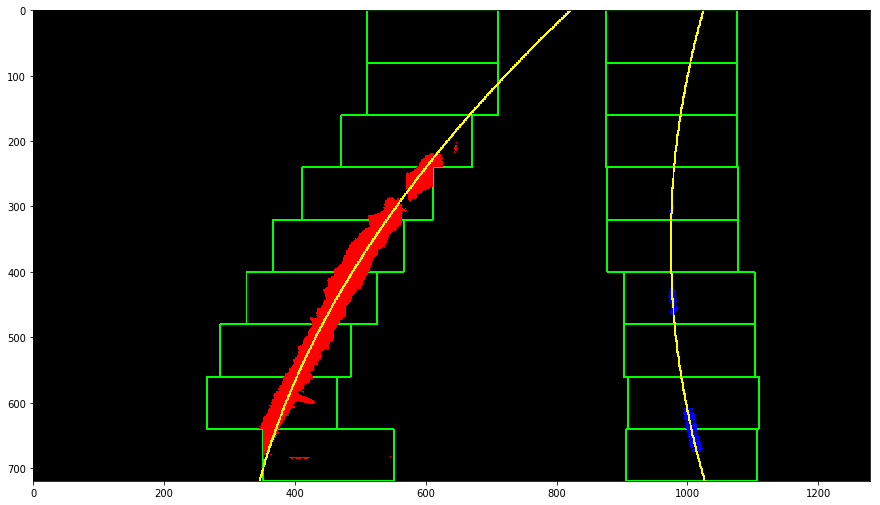

In [16]:
# Load our image and visualize sliding windows with fit line
orig_img = mpimg.imread('test_images/challenge1.jpg')
undistorted_img = undistort_image(orig_img, mtx, dist)
binary_warped_img = binary_warped(undistorted_img, M)

left_line = Line()
right_line = Line()
left_line, right_line, ploty = fit_polynomial(binary_warped_img, left_line, right_line)
viz_img = visualize_sliding_windows(binary_warped_img, left_line, right_line)
plt.imshow(viz_img)

In [17]:
## SEARCH FROM PRIOR
def search_around_poly(binary_warped, left_line, right_line):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_line.best_fit[0]*(nonzeroy**2) + left_line.best_fit[1]*nonzeroy + 
                    left_line.best_fit[2] - margin)) & (nonzerox < (left_line.best_fit[0]*(nonzeroy**2) + 
                    left_line.best_fit[1]*nonzeroy + left_line.best_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_line.best_fit[0]*(nonzeroy**2) + right_line.best_fit[1]*nonzeroy + 
                    right_line.best_fit[2] - margin)) & (nonzerox < (right_line.best_fit[0]*(nonzeroy**2) + 
                    right_line.best_fit[1]*nonzeroy + right_line.best_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    left_line.allx = nonzerox[left_lane_inds]
    left_line.ally = nonzeroy[left_lane_inds] 
    right_line.allx = nonzerox[right_lane_inds]
    right_line.ally = nonzeroy[right_lane_inds]
    
    if len(left_line.allx) > 0 and len(right_line.allx) > 0:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_line.fit(ploty)
        right_line.fit(ploty)
        
    left_line.search_windows = None
    right_line.search_windows = None
    left_line.search_margin = margin
    right_line.search_margin = margin
    
    return ploty

In [18]:
def visualize_search_around(binary_warped_img, left_line, right_line):    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))*255
    window_img = np.zeros_like(out_img)
    
    # Grab activated pixels
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Color in left and right line pixels
    out_img[left_line.ally, left_line.allx] = [255, 0, 0]
    out_img[right_line.ally, right_line.allx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_line.bestx-left_line.search_margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line.bestx+left_line.search_margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_line.bestx-right_line.search_margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx+right_line.search_margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255,0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255,0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))], np.int32)
    cv2.polylines(result,[left],False,(255,255, 0), thickness = 2)
    
    right = np.array([np.transpose(np.vstack([right_line.bestx, ploty]))], np.int32)
    cv2.polylines(result,[right],False,(255,255, 0), thickness = 2)
    
    return result

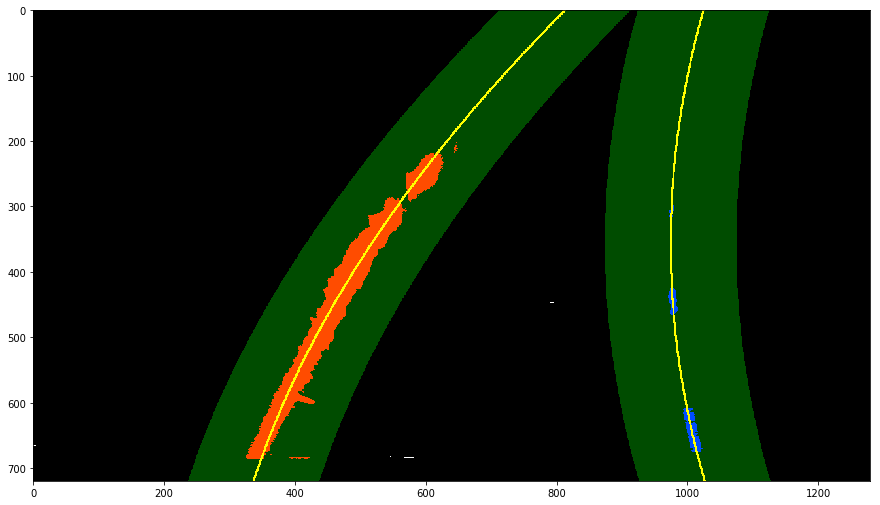

In [19]:
ploty = search_around_poly(binary_warped_img, left_line, right_line)
viz_img = visualize_search_around(binary_warped_img, left_line, right_line)
plt.imshow(viz_img)


## 5. Curvature

In [20]:
ym_per_pix = 30/720 # meters per pixel in y dimension  
xm_per_pix = 3.7/800 # meters per pixel in x dimension

def calculate_r_curve(line, y_eval):
    if len(line.ally) == 0 or len(line.allx) == 0:
        return 0
    
    curve_fit = np.polyfit(line.ally*ym_per_pix, line.allx*xm_per_pix, 2)
    return ((1 + (2*curve_fit[0]*y_eval*ym_per_pix + curve_fit[1])**2)**1.5) / np.absolute(2*curve_fit[0])

def measure_curvature_pixels(ploty, left_line, right_line):
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = calculate_r_curve(left_line, y_eval)
    right_curverad = calculate_r_curve(right_line, y_eval)
    
    return left_curverad, right_curverad

def calculate_vehicle_from_center(orig_img, left_line, right_line):
    x_max = orig_img.shape[1]
    y_max = orig_img.shape[0]
    
    line_left = left_line.best_fit[0]*y_max**2 + left_line.best_fit[1]*y_max + left_line.best_fit[2]
    line_right = right_line.best_fit[0]*y_max**2 + right_line.best_fit[1]*y_max + right_line.best_fit[2]
    line_middle = line_left + (line_right - line_left)/2
    
    vehicle_center = x_max / 2
    diff = (line_middle - vehicle_center) * xm_per_pix
    return diff
    

left_curv, right_curv = measure_curvature_pixels(ploty, left_line, right_line)
print("Left curvature: ", left_curv)
print("Right curvature: ", right_curv)
      
distance_from_center = calculate_vehicle_from_center(orig_img, left_line, right_line)
print("From center: ", distance_from_center)

Left curvature:  407.091340397
Right curvature:  476.566778824
From center:  0.195556620506


## 6. Draw lines

In [21]:
from moviepy.editor import VideoFileClip
from moviepy.video.io.bindings import mplfig_to_npimage
from IPython.display import HTML

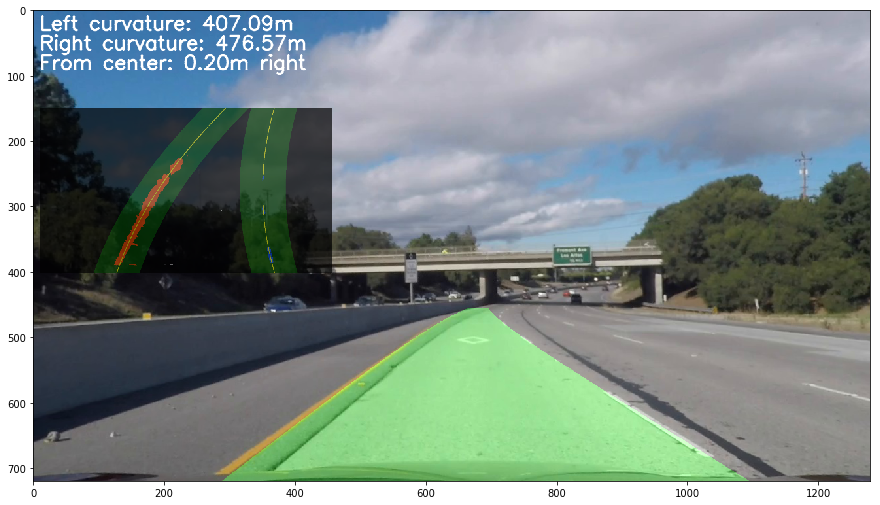

In [22]:
def add_curvature(img, left_line, right_line):
    left_curv, right_curv = measure_curvature_pixels(ploty, left_line, right_line)
    from_center = calculate_vehicle_from_center(img, left_line, right_line)
    direction = 'right' if from_center > 0 else 'left'
    
    cv2.putText(img, 'Left curvature: {:.2f}m'.format(left_curv),(10,30), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img, 'Right curvature: {:.2f}m'.format(right_curv),(10,60), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img, 'From center: {:.2f}m {}'.format(abs(from_center), direction), (10,90), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)

def add_heuristics(target_img, binary_warped_img, left_line, right_line):
    if left_line.search_margin == None:
        viz_img = visualize_sliding_windows(binary_warped_img, left_line, right_line)
        
    else:
        viz_img = visualize_search_around(binary_warped_img, left_line, right_line)
        
    small_viz_img = cv2.resize(viz_img, (0,0), fx=0.35, fy=0.35)
    rows,cols,channels = small_viz_img.shape
    positionx = 10
    positiony = 150
    overlay = cv2.addWeighted(target_img[positiony:positiony+rows, positionx:positionx+cols], 0.3, small_viz_img, 0.5, 0)
    target_img[positiony:positiony+rows, positionx:positionx+cols ] = overlay
    
def draw_lines(orig_img, binary_warped_img, left_line, right_line, ploty, draw_heuristics=True, draw_lines=True): 

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (orig_img.shape[1], orig_img.shape[0])) 
    # Combine the result with the original image
    if draw_lines:
        result = cv2.addWeighted(orig_img, 1, newwarp, 0.3, 0)
    else:
        result = orig_img
    
    if draw_heuristics:
        add_curvature(result, left_line, right_line)
        add_heuristics(result, binary_warped_img, left_line, right_line)
    return result

img_with_lines = draw_lines(undistorted_img, binary_warped_img, left_line, right_line, ploty, True, True)
plt.imshow(img_with_lines)

## Video

In [23]:
from scipy.signal import savgol_filter

class LaneFinder():
    def __init__(self):
        self.right_line = Line()
        self.left_line = Line()
        self.draw_heuristics = True
        self.draw_lines = True
    
    def process_image(self, orig_img):
        undistorted_img = undistort_image(orig_img, mtx, dist)
        warped_img = cv2.warpPerspective(undistorted_img, M, img_size, flags=cv2.INTER_LINEAR)
        binary_warped_img = pipeline(warped_img)

        if self.left_line.detected == True and self.right_line.detected == True:
            try:
                ploty = search_around_poly(binary_warped_img, self.left_line, self.right_line)
            except:
                # searching with prior failed, force full search
                self.left_line.detected = False
                self.right_line.detected = False
        
        if self.left_line.detected == False or self.right_line.detected == False:
            try:
                self.left_line, self.right_line, ploty = fit_polynomial(binary_warped_img, self.left_line, self.right_line)
            except:
                self.left_line.detected = False
                self.right_line.detected = False
                return orig_img
            
        img_with_lines = draw_lines(undistorted_img, binary_warped_img, self.left_line, self.right_line, ploty, self.draw_heuristics, self.draw_lines)
        return img_with_lines
    
    def process_frame_callback(self):
        return lambda img: self.process_image(img)

In [24]:
inputVideoClip = VideoFileClip('project_video.mp4')
outputVideoName = 'project_video_output.mp4'

laneFinder = LaneFinder()
laneFinder.left_line.smoothing_window = 51
laneFinder.right_line.smoothing_window = 51
outputVideoClip = inputVideoClip.fl_image(laneFinder.process_frame_callback())
%time outputVideoClip.write_videofile(outputVideoName, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:28<00:00,  6.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 12min 57s, sys: 1min 16s, total: 14min 13s
Wall time: 3min 29s


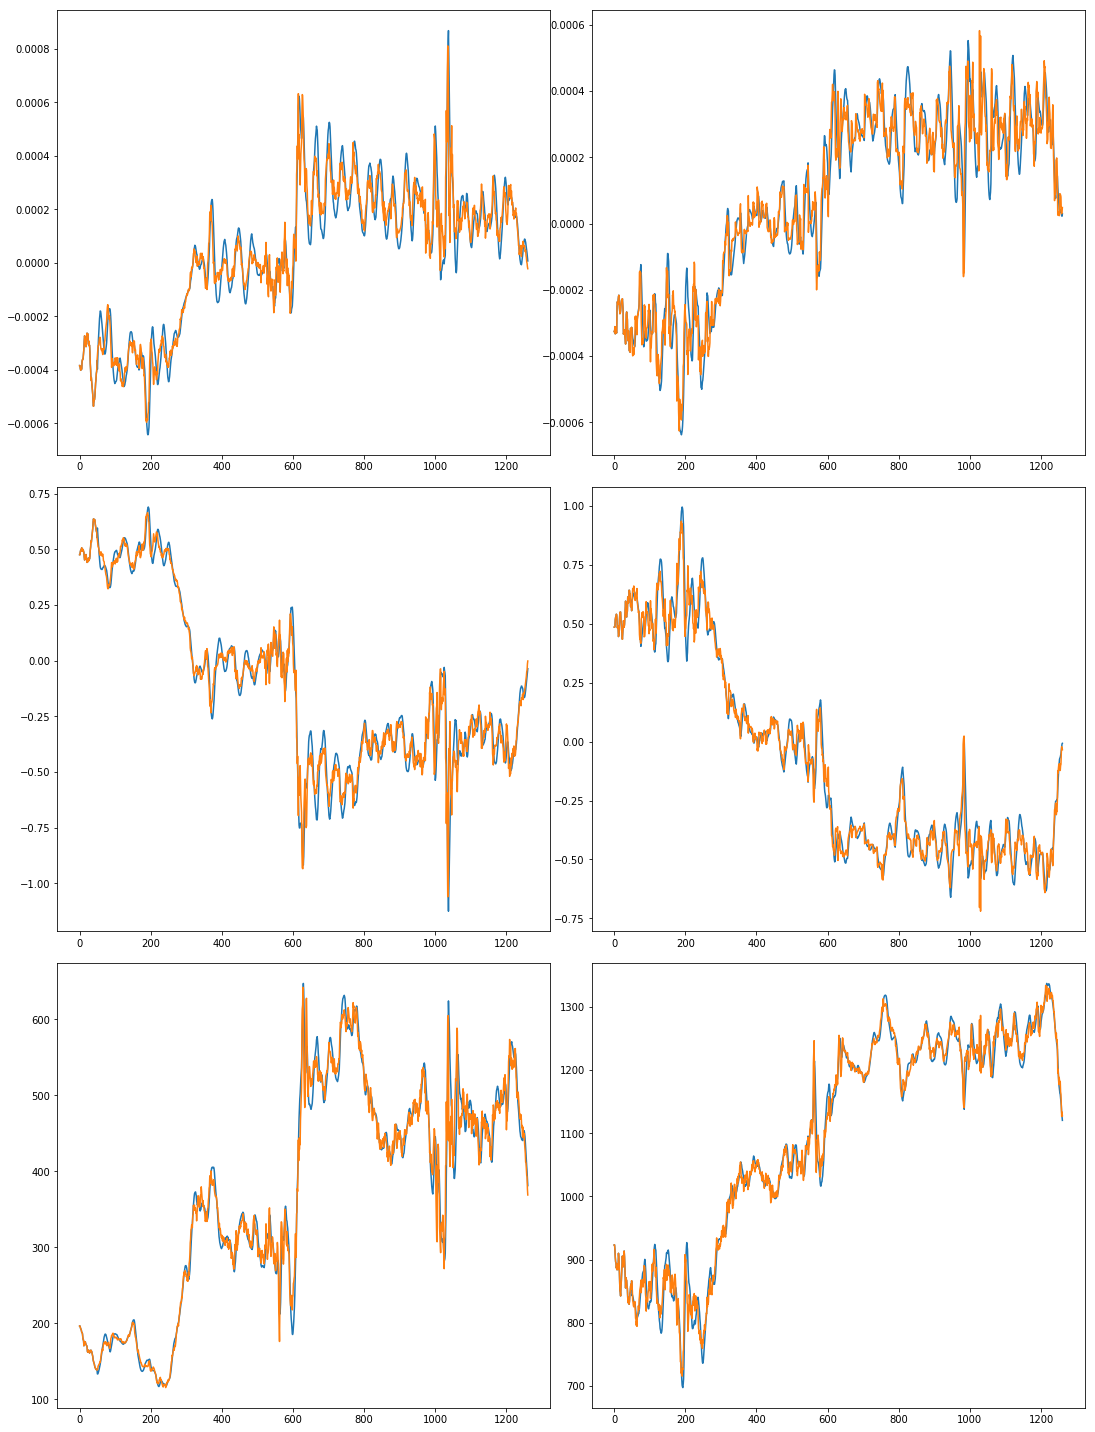

In [25]:
def displaySmoothing(laneFinder):
    fig, axs = plt.subplots(3, 2, figsize=(15, 20))
    fig.tight_layout()

    axs0 = axs[0][0]
    axs0.plot(np.array(laneFinder.left_line.best_fit_history)[:,0])
    axs0.plot(np.array(laneFinder.left_line.current_fit)[:,0])

    axs1 = axs[0][1]
    axs1.plot(np.array(laneFinder.right_line.best_fit_history)[:,0])
    axs1.plot(np.array(laneFinder.right_line.current_fit)[:,0])

    axs2 = axs[1][0]
    axs2.plot(np.array(laneFinder.left_line.best_fit_history)[:,1])
    axs2.plot(np.array(laneFinder.left_line.current_fit)[:,1])

    axs3 = axs[1][1]
    axs3.plot(np.array(laneFinder.right_line.best_fit_history)[:,1])
    axs3.plot(np.array(laneFinder.right_line.current_fit)[:,1])

    axs4 = axs[2][0]
    axs4.plot(np.array(laneFinder.left_line.best_fit_history)[:,2])
    axs4.plot(np.array(laneFinder.left_line.current_fit)[:,2])

    axs5 = axs[2][1]
    axs5.plot(np.array(laneFinder.right_line.best_fit_history)[:,2])
    axs5.plot(np.array(laneFinder.right_line.current_fit)[:,2])
    
displaySmoothing(laneFinder)

In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outputVideoName))

In [27]:
inputChallengeVideoClip = VideoFileClip('challenge_video.mp4')
outputChallengeVideoName = 'challenge_video_output.mp4'

laneFinderChallenge = LaneFinder()
#laneFinder.draw_lines = False
laneFinderChallenge.left_line.smoothing_window = 101
laneFinderChallenge.right_line.smoothing_window = 101

outputChallengeVideoClip = inputChallengeVideoClip.fl_image(laneFinderChallenge.process_frame_callback())
%time outputChallengeVideoClip.write_videofile(outputChallengeVideoName, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:16<00:00,  6.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 4min 33s, sys: 25.9 s, total: 4min 59s
Wall time: 1min 17s


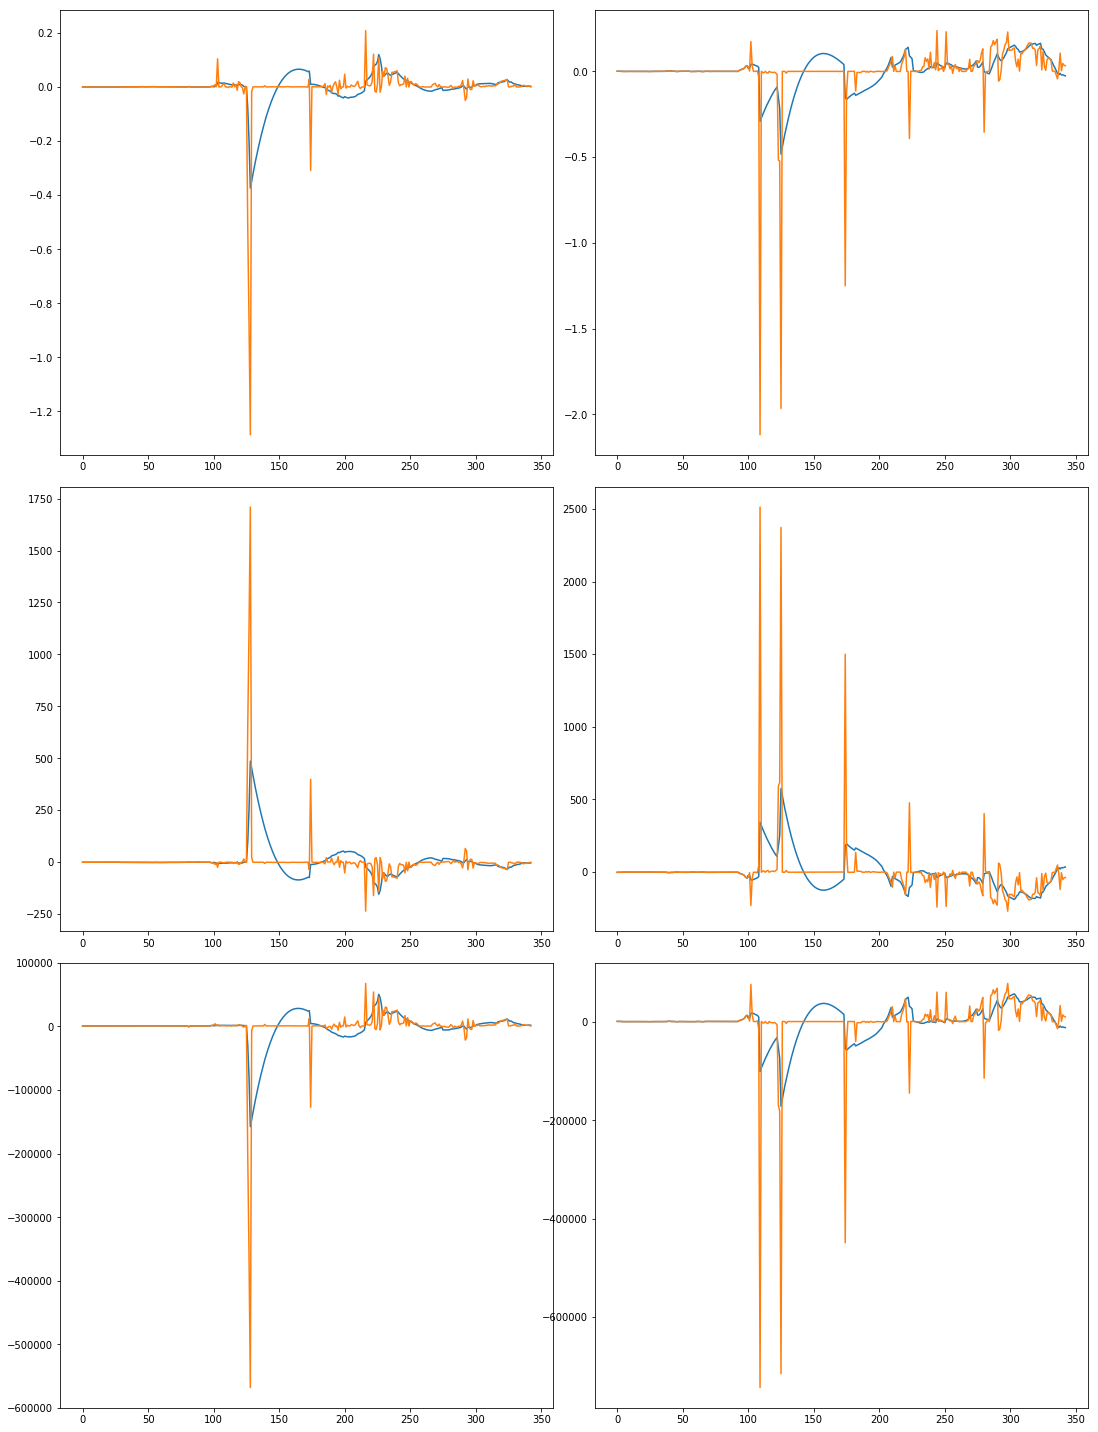

In [28]:
displaySmoothing(laneFinderChallenge)

In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outputChallengeVideoName))

In [30]:
inputHarderVideoClip = VideoFileClip('harder_challenge_video.mp4')
outputHarderVideoName = 'harder_challenge_video_output.mp4'

laneFinderHarder = LaneFinder()
laneFinderHarder.left_line.smoothing_window = 101
laneFinderHarder.right_line.smoothing_window = 101
outputHarderVideoClip = inputHarderVideoClip.fl_image(laneFinderHarder.process_frame_callback())
%time outputHarderVideoClip.write_videofile(outputHarderVideoName, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [03:34<00:00,  5.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 12min 58s, sys: 1min 12s, total: 14min 11s
Wall time: 3min 36s


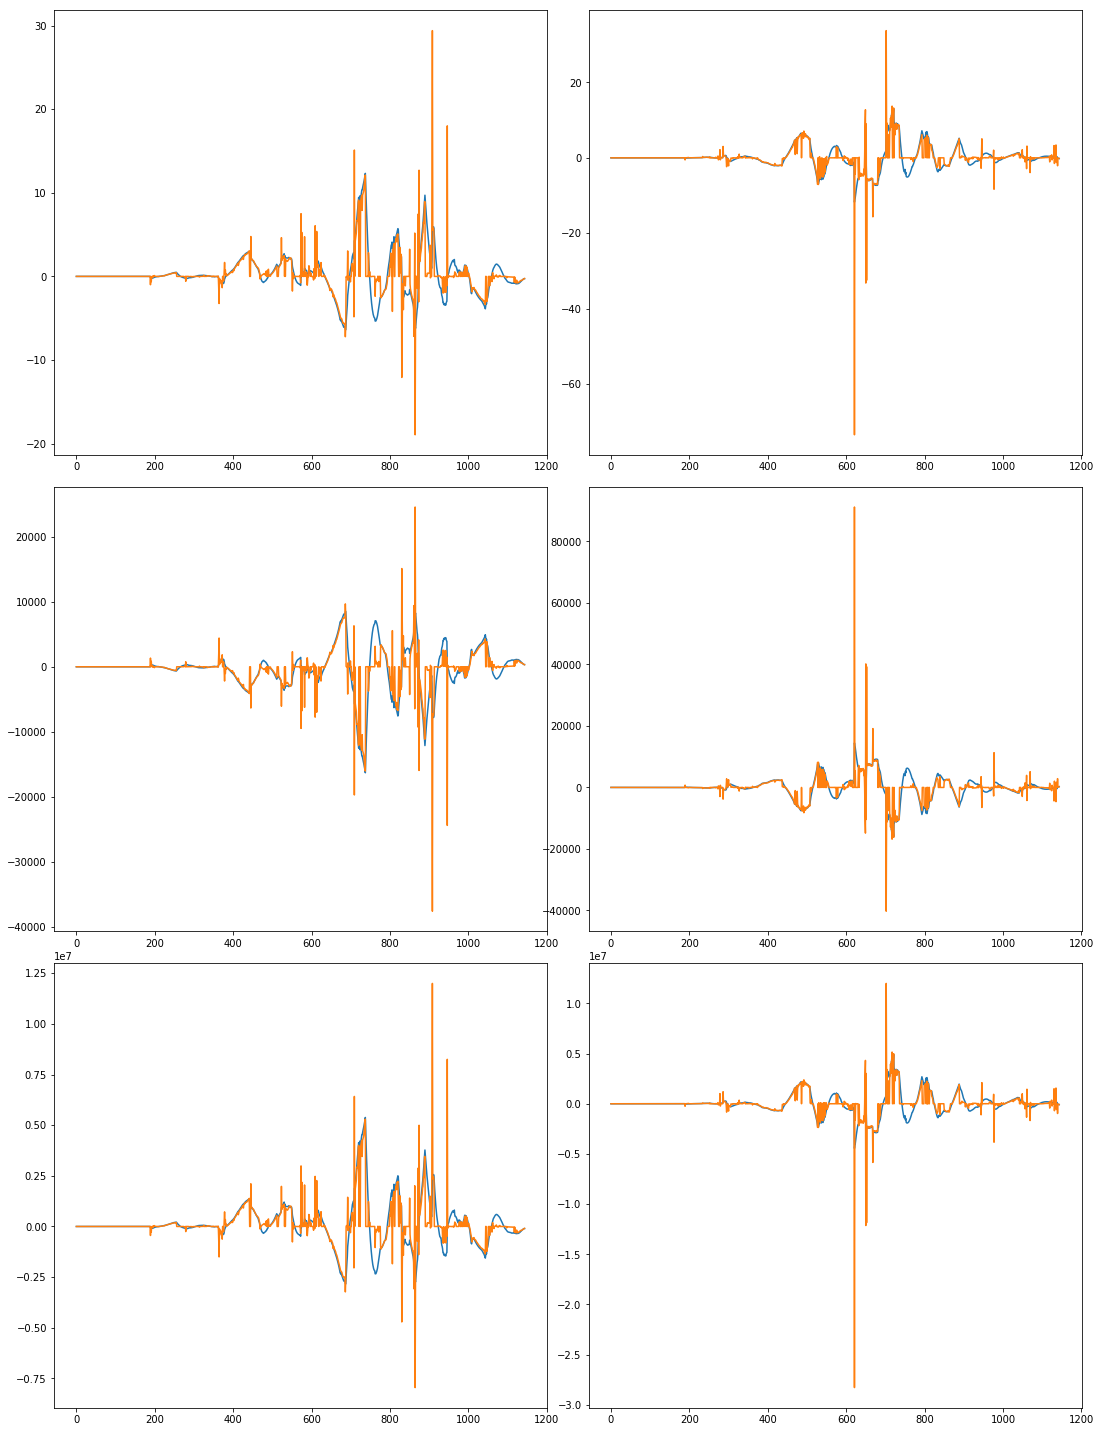

In [31]:
displaySmoothing(laneFinderHarder)

In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outputHarderVideoName))